In [323]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import r2_score

In [324]:
df_train.describe()

,incident_hour,zipcode,crime,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9.874000e+03,9874.000000
mean,11.925360,94116.662751,14.692627,32848.934981,23281.650800,15732.974276,14425.981365,7.724463e+05,75871.021369
std,6.786943,14.073532,18.234443,20236.401505,13331.307311,8928.712598,8257.802916,1.543596e+05,32335.456439
min,0.000000,94102.000000,1.000000,406.000000,5232.000000,368.000000,207.000000,4.704000e+05,22517.000000
25%,6.000000,94107.000000,2.000000,23088.000000,12926.000000,10769.000000,9717.000000,6.280000e+05,48750.000000
50%,12.000000,94114.000000,7.000000,31176.000000,20036.000000,15141.000000,13736.000000,7.682000e+05,81768.000000
75%,18.000000,94123.000000,20.000000,40798.000000,29596.000000,19255.000000,17939.000000,9.115000e+05,94479.000000
max,23.000000,94158.000000,140.000000,79407.000000,50983.000000,37182.000000,33342.000000,1.000001e+06,163949.000000


In [325]:
df_train = pd.read_csv("df_train.csv").dropna()
df_test = pd.read_csv("df_test.csv").dropna()

In [326]:
# Use one-hot encoding for categorical variable
X_train_raw = df_train.drop(columns = ['crime','police_district'])
X_test_raw = df_test.drop(columns = ['crime','police_district'])
X_train_dummy = pd.get_dummies(X_train_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)
X_test_dummy = pd.get_dummies(X_test_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)

In [327]:
# Standardize the numerical columns.
def standardize(df, cols, df_train):
    scalar = StandardScaler().fit(df_train[cols])
    result = df.copy()
    transformed_cols = scalar.transform(result[cols])
    result = result.drop(cols, 1)
    for i in range(len(cols)): 
        col = cols[i]
        result[col] = transformed_cols[:, i]
    return result
cols = ['population','population_density','housing_units',
        'occupied_housing_units','median_home_value','median_household_income']
X_train_clean = standardize(X_train_dummy,cols,X_train_dummy)
X_test_clean = standardize(X_test_dummy,cols,X_train_dummy)
X_train_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,...,9874.000000,9874.000000,9874.000000,9874.000000,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03
mean,0.143711,0.142192,0.138141,0.142293,0.143204,0.144318,0.035548,0.035143,0.033421,0.033016,...,0.046790,0.021065,0.038687,0.061981,1.539740e-16,-1.772039e-17,5.415064e-17,1.637112e-17,6.906568e-17,2.735136e-16
std,0.350814,0.349264,0.345065,0.349368,0.350299,0.351430,0.185169,0.184150,0.179743,0.178687,...,0.211198,0.143610,0.192859,0.241133,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.603278e+00,-1.353998e+00,-1.720937e+00,-1.721972e+00,-1.956870e+00,-1.650100e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.823698e-01,-7.768312e-01,-5.559845e-01,-5.702752e-01,-9.358253e-01,-8.387819e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-8.267377e-02,-2.434731e-01,-6.630343e-02,-8.355931e-02,-2.751042e-02,1.823780e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.928301e-01,4.736721e-01,3.944806e-01,4.254396e-01,9.008884e-01,5.754958e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.300825e+00,2.078022e+00,2.402375e+00,2.290800e+00,1.474261e+00,2.724020e+00


In [328]:
X_train_binary = X_train_dummy.copy()
X_train_binary = X_train_binary.drop(columns= cols)
X_test_binary = X_test_dummy.copy()
X_test_binary = X_test_binary.drop(columns= cols)

In [329]:
X_test_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.00000,9854.000000,...,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000
mean,0.142785,0.140857,0.140045,0.142683,0.143597,0.142277,0.036939,0.035214,0.03491,0.032474,...,0.050233,0.020093,0.038259,0.061701,0.002508,0.002585,0.008927,0.008820,-0.002025,0.002931
std,0.349871,0.347891,0.347051,0.349767,0.350698,0.349352,0.188622,0.184330,0.18356,0.177265,...,0.218437,0.140327,0.191830,0.240624,0.989685,0.997469,0.994948,0.994554,0.995698,0.998357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.603278,-1.353998,-1.720937,-1.721972,-1.956870,-1.650100
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.482370,-0.776831,-0.555984,-0.570275,-0.935825,-0.838782
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.082674,-0.243473,-0.066303,-0.083559,-0.027510,0.182378
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.392830,0.473672,0.394481,0.425440,0.900888,0.575496
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.300825,2.078022,2.402375,2.290800,1.474261,2.724020


In [330]:
# Get y_train and y_test
y_train = df_train.crime
y_test = df_test.crime

## Base

In [331]:
df_train.sort_values(by = 'crime',ascending = False).head(20)

,incident_day_of_week,police_district,incident_hour,zipcode,crime,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
1446,Friday,Tenderloin,15,94103.0,140,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
4787,Sunday,Mission,0,94110.0,131,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
7782,Tuesday,Mission,18,94110.0,130,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
3355,Saturday,Mission,0,94110.0,128,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
10087,Wednesday,Tenderloin,15,94103.0,120,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
5387,Sunday,Southern,0,94103.0,119,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
8630,Tuesday,Tenderloin,15,94103.0,117,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
2012,Monday,Mission,16,94110.0,115,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
10076,Wednesday,Tenderloin,13,94103.0,113,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
1157,Friday,Southern,12,94103.0,113,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0


We notice that most of crimes happend at places where zipcode are 94103 and 94110.

## Linear Regression

In [332]:
# Check colinearity
X_numerical = X_train_clean[cols]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]
vif["features"] = X_numerical.columns
vif.round(1)

,VIF Factor,features
0,21.5,population
1,2.8,population_density
2,1879.9,housing_units
3,2159.5,occupied_housing_units
4,2.0,median_home_value
5,1.7,median_household_income


In [333]:
# Dropout columns with huge VIF Factor
X_train_final = X_train_clean.drop(columns=['population','housing_units','occupied_housing_units'])
X_test_final = X_test_clean.drop(columns=['population','housing_units','occupied_housing_units'])

In [355]:
OS =LinearRegression()
OS.fit(X_train_final,y_train)
y_pred_lr = OS.predict(X_test_final)
MSE_lr =mse(y_pred_lr,y_test)
print("R square for NN method is:",r2_score(y_pred_lr,y_test))
print("MSE error for linear regression method is:",MSE_lr)

R square for NN method is: -2.863269081181666
MSE error for linear regression method is: 242.18510968129993


Text(0, 0.5, 'Number of Crime')

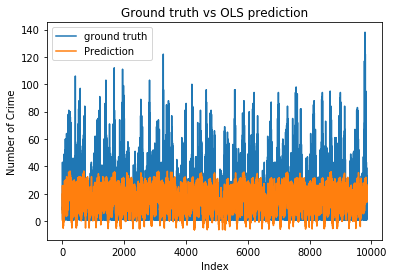

In [336]:
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_lr,label = "Prediction")
plt.legend()
plt.title("Ground truth vs OLS prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## Regularization


### LASSO Regression

In [354]:
lam = [0.0001,0.01,0.1,0.5,1,5,10,50,100]
# Fit the LASSO model
model_lasso = LassoCV(alphas = lam, max_iter = 100000,fit_intercept = True, cv = 5)
model_lasso.fit(X_train_final,y_train)
print("The best alpha for lasso is %s" %model_lasso.alpha_)
y_pred_lasso = model_lasso.predict(X_test_final)
MSE_lasso =mse(y_pred_lasso,y_test)
print("MSE error for LASSO regression method is:",MSE_lasso)
print("R square for NN method is:",r2_score(y_pred_lasso,y_test))

The best alpha for lasso is 0.01
MSE error for LASSO regression method is: 241.88350530051574
R square for NN method is: -3.1011809570681095


Text(0, 0.5, 'Number of Crime')

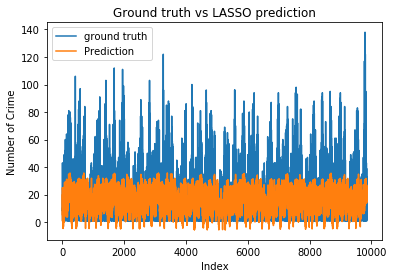

In [338]:
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_lasso,label = "Prediction")
plt.legend()
plt.title("Ground truth vs LASSO prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

### Ridge Regression

In [353]:
# Fit the Ridge model
model_ridge = RidgeCV(alphas = lam,fit_intercept = True,cv = 5)
model_ridge.fit(X_train_final,y_train)
print("The best alpha for ridge is %s" %model_ridge.alpha_)
print("R square for NN method is:",r2_score(y_pred_ridge,y_test))
y_pred_ridge = model_ridge.predict(X_test_final)
MSE_ridge =mse(y_pred_ridge,y_test)
print("MSE error for Ridge regression method is:",MSE_ridge)

The best alpha for ridge is 5.0
R square for NN method is: -2.947736957987154
MSE error for Ridge regression method is: 242.041617104608


Text(0, 0.5, 'Number of Crime')

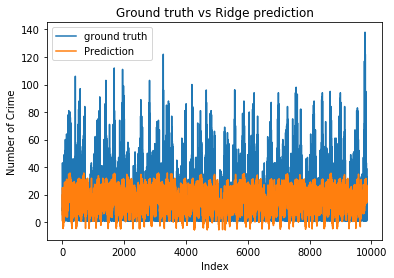

In [340]:
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_lasso,label = "Prediction")
plt.legend()
plt.title("Ground truth vs Ridge prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## Random Forest

MSE error for Random Forest method is: 257.77444370697805
R square for NN method is: -1.5420382294180164


Text(0, 0.5, 'Number of Crime')

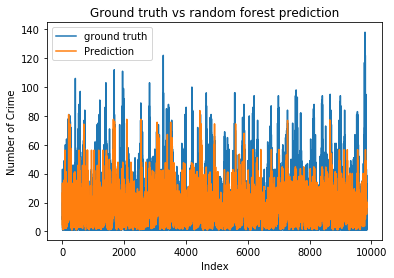

In [352]:
rf = RandomForestRegressor()
rf.fit(X_train_final,y_train)
y_pred_rf = rf.predict(X_test_final)
MSE_rf =mse(y_pred_rf,y_test)
print("MSE error for Random Forest method is:",MSE_rf)
print("R square for NN method is:",r2_score(y_pred_rf,y_test))
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_rf,label = "Prediction")
plt.legend()
plt.title("Ground truth vs random forest prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

In [342]:
list(zip(X_train_final.columns, rf.feature_importances_))

[('incident_day_of_week_Monday', 0.044017908133182106),
 ('incident_day_of_week_Saturday', 0.04441163744433469),
 ('incident_day_of_week_Sunday', 0.04426482967654845),
 ('incident_day_of_week_Thursday', 0.045547338166554395),
 ('incident_day_of_week_Tuesday', 0.049060745393161125),
 ('incident_day_of_week_Wednesday', 0.05018517370065335),
 ('incident_hour_1', 0.011474533346639402),
 ('incident_hour_2', 0.011812391931200138),
 ('incident_hour_3', 0.014944061322339134),
 ('incident_hour_4', 0.019656945758813205),
 ('incident_hour_5', 0.018854826224442647),
 ('incident_hour_6', 0.01524712743651698),
 ('incident_hour_7', 0.011697690750428579),
 ('incident_hour_8', 0.010579180414368497),
 ('incident_hour_9', 0.011292409945708404),
 ('incident_hour_10', 0.01451051780437341),
 ('incident_hour_11', 0.015627447751642307),
 ('incident_hour_12', 0.02452451558550035),
 ('incident_hour_13', 0.018035964129087773),
 ('incident_hour_14', 0.018250949263427043),
 ('incident_hour_15', 0.01939754303107859

## SVM

MSE error for SVM method is: 294.96319017222913
R square for NN method is: -17.707635162317825


Text(0, 0.5, 'Number of Crime')

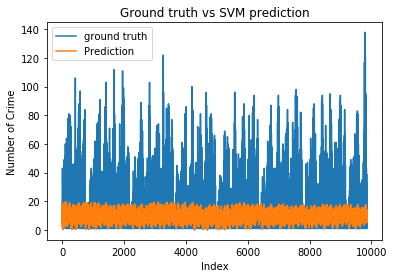

In [351]:
### SVM
svm = SVR()
svm.fit(X_train_final,y_train)
y_pred_svm = svm.predict(X_test_final)
MSE_svm =mse(y_pred_svm,y_test)
print("MSE error for SVM method is:",MSE_svm)
print("R square for NN method is:",r2_score(y_pred_svm,y_test))
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_svm,label = "Prediction")
plt.legend()
plt.title("Ground truth vs SVM prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## KNN

R square for NN method is: -2.1807872192714606
MSE error for KNN method is: 264.4894986807388


Text(0, 0.5, 'Number of Crime')

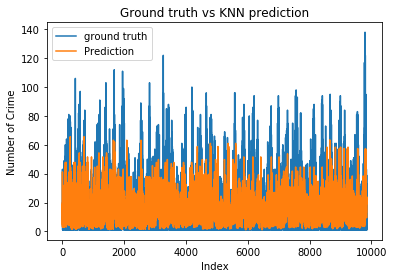

In [350]:
KNN = KNeighborsRegressor()
KNN.fit(X_train_final,y_train)
y_pred_KNN = KNN.predict(X_test_final)
MSE_KNN =mse(y_pred_KNN,y_test)
print("R square for NN method is:",r2_score(y_pred_KNN,y_test))
print("MSE error for KNN method is:",MSE_KNN)
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_KNN,label = "Prediction")
plt.legend()
plt.title("Ground truth vs KNN prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## Neural Network

In [345]:
from tensorflow.keras import layers
validation_split = 0.2
epochs = 20
optimizer = tf.keras.optimizers.RMSprop(0.001)
model = tf.keras.models.Sequential()
model.add(layers.Dense(units=100, activation='relu',input_dim = 54))
#model.add(layers.Dense(units=64, activation='linear'))
model.add(layers.Dense(units=1, activation='relu'))
model.compile(loss = 'mse', optimizer = optimizer)
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 100)               5500      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 101       
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [346]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train_final, y_train, batch_size=64, epochs=epochs, 
                    validation_split=validation_split, verbose=1,
                   callbacks=[early_stop])

Train on 7899 samples, validate on 1975 samples
Epoch 1/20
7899/7899 [==============================] - 1s 65us/sample - loss: 472.8134 - val_loss: 431.6921
Epoch 2/20
7899/7899 [==============================] - 0s 22us/sample - loss: 347.3055 - val_loss: 338.7660
Epoch 3/20
7899/7899 [==============================] - 0s 18us/sample - loss: 301.9525 - val_loss: 315.8288
Epoch 4/20
7899/7899 [==============================] - 0s 18us/sample - loss: 289.5794 - val_loss: 305.3195
Epoch 5/20
7899/7899 [==============================] - 0s 22us/sample - loss: 281.0865 - val_loss: 298.5255
Epoch 6/20
7899/7899 [==============================] - 0s 21us/sample - loss: 275.8560 - val_loss: 293.0628
Epoch 7/20
7899/7899 [==============================] - 0s 20us/sample - loss: 272.5977 - val_loss: 289.6171
Epoch 8/20
7899/7899 [==============================] - 0s 22us/sample - loss: 270.6707 - val_loss: 287.8518
Epoch 9/20
7899/7899 [==============================] - 0s 18us/sample - loss: 2

Text(0, 0.5, 'Number of Crime')

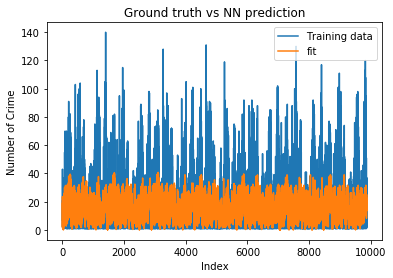

In [363]:
plt.plot(np.arange(len(y_train)),y_train,label = "Training data")
plt.plot(np.arange(len(y_train)),model.predict(X_train_final),label = "fit")
plt.legend()
plt.title("Ground truth vs NN prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

MSE error for NN method is: 239.6911120177265
R square for NN method is: -2.754899558000575


Text(0, 0.5, 'Number of Crime')

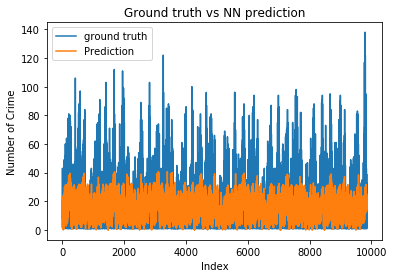

In [362]:
y_pred_NN = model.predict(X_test_final)
MSE_NN =mse(y_pred_NN,y_test)
print("MSE error for NN method is:",MSE_NN)
print("R square for NN method is:",r2_score(y_pred_NN,y_test))
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_NN,label = "Prediction")
plt.legend()
plt.title("Ground truth vs NN prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

In [360]:
print("R square for baseline method is:",r2_score([np.mean(y_test) for i in y_test],y_test))
print("R square for baseline method is:",mse([np.mean(y_test) for i in y_test],y_test))

R square for baseline method is: 0.0
R square for baseline method is: 292.5302685804999
